In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


In [2]:
# Read the CSV file
df = pd.read_csv('scaled_test_data_concatenated_v2.csv')

# Convert the 'Position 1' column to dummy variables
df = pd.get_dummies(df, columns=['Position 1'], drop_first=False)

# Display the first few rows of the modified dataframe
df.head()

,Player,Team,Age,Market value,Birth country,Height,Weight,Goals,xG,Assists,...,Position 1_CF,Position 1_CM,Position 1_DMF,Position 1_GK,Position 1_LB,Position 1_LW,Position 1_LWB,Position 1_RB,Position 1_RW,Position 1_RWB
0,Hugo Bueno,Wolverhampton Wanderers,-1.650487,200000,Spain,-0.386910,-0.419228,-0.713102,-0.786288,-0.248585,...,False,False,False,False,True,False,False,False,False,False
1,Jonny Otto,Wolverhampton Wanderers,0.537946,17000000,Spain,-1.131609,-0.840882,-0.421577,-0.744785,-0.772397,...,False,False,False,False,False,False,False,True,False,False
2,C. Dawson,Wolverhampton Wanderers,1.510582,2500000,England,0.804608,0.283530,-0.421577,-0.163734,-0.772397,...,False,False,False,False,False,False,False,False,False,False
3,Matheus Nunes,Wolverhampton Wanderers,-0.677850,45000000,Brazil,0.208849,0.283530,-0.421577,0.078903,-0.248585,...,False,False,False,False,False,False,False,False,False,False
4,R. Aït Nouri,Wolverhampton Wanderers,-1.407328,22000000,France,-0.386910,-0.840882,-0.421577,-0.435104,-0.772397,...,False,False,False,False,True,False,False,False,False,False


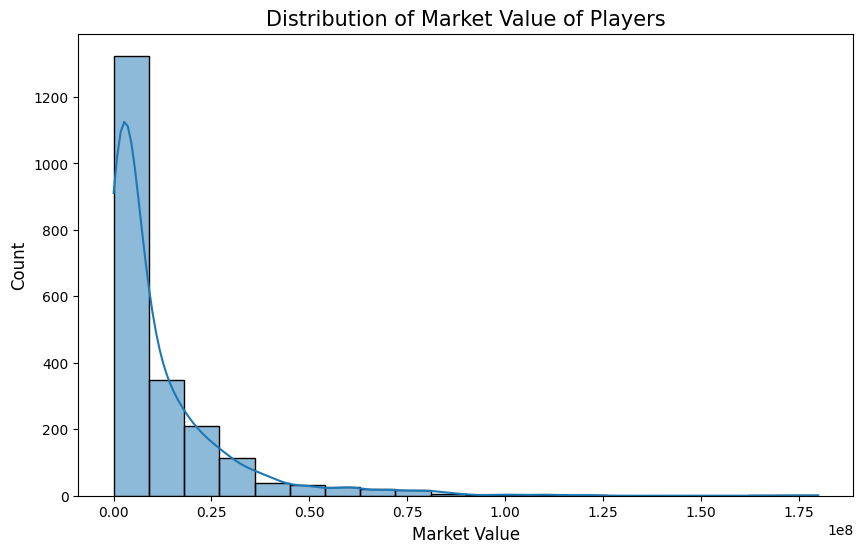

In [3]:
# Distribution of Market Value of Players

plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Market value', bins=20, kde=True)
plt.title('Distribution of Market Value of Players', fontsize=15)
plt.xlabel('Market Value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

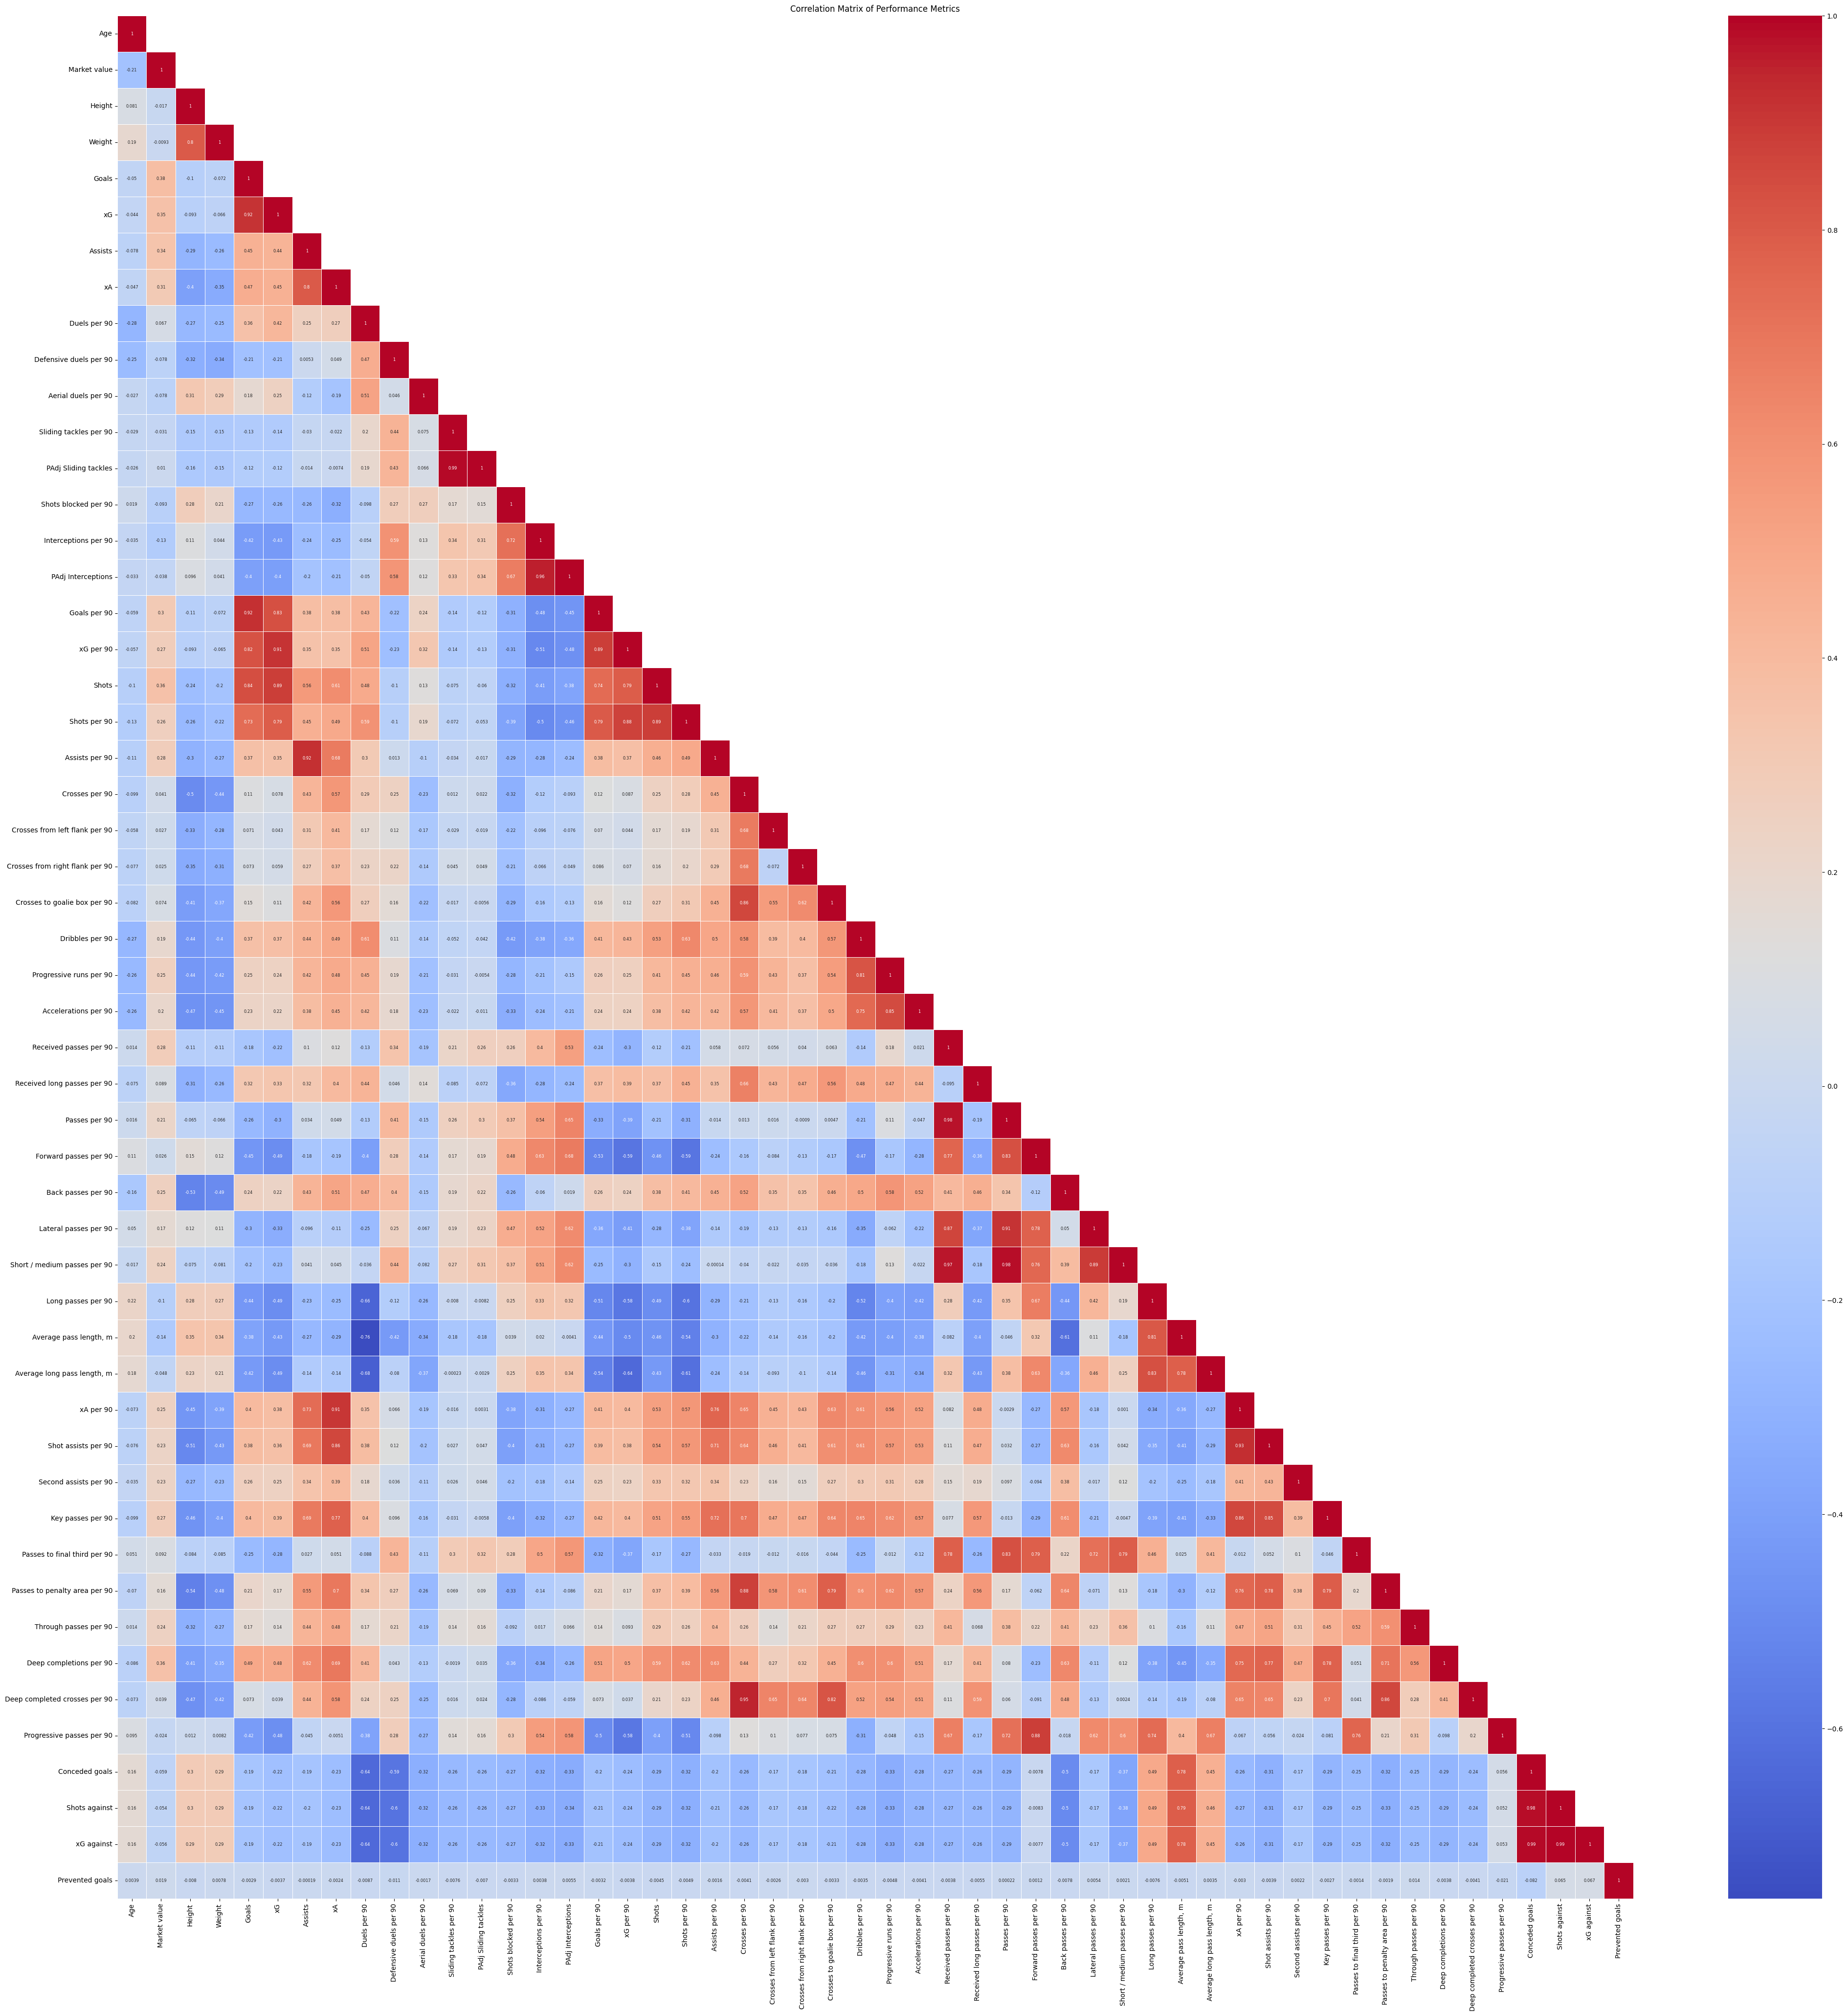

In [4]:
# Step 1: Select only numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Step 2: Compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Step 3: Plot the correlation matrix
plt.figure(figsize=(50,50))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask, annot_kws={"size": 6})
plt.title('Correlation Matrix of Performance Metrics')
plt.show()

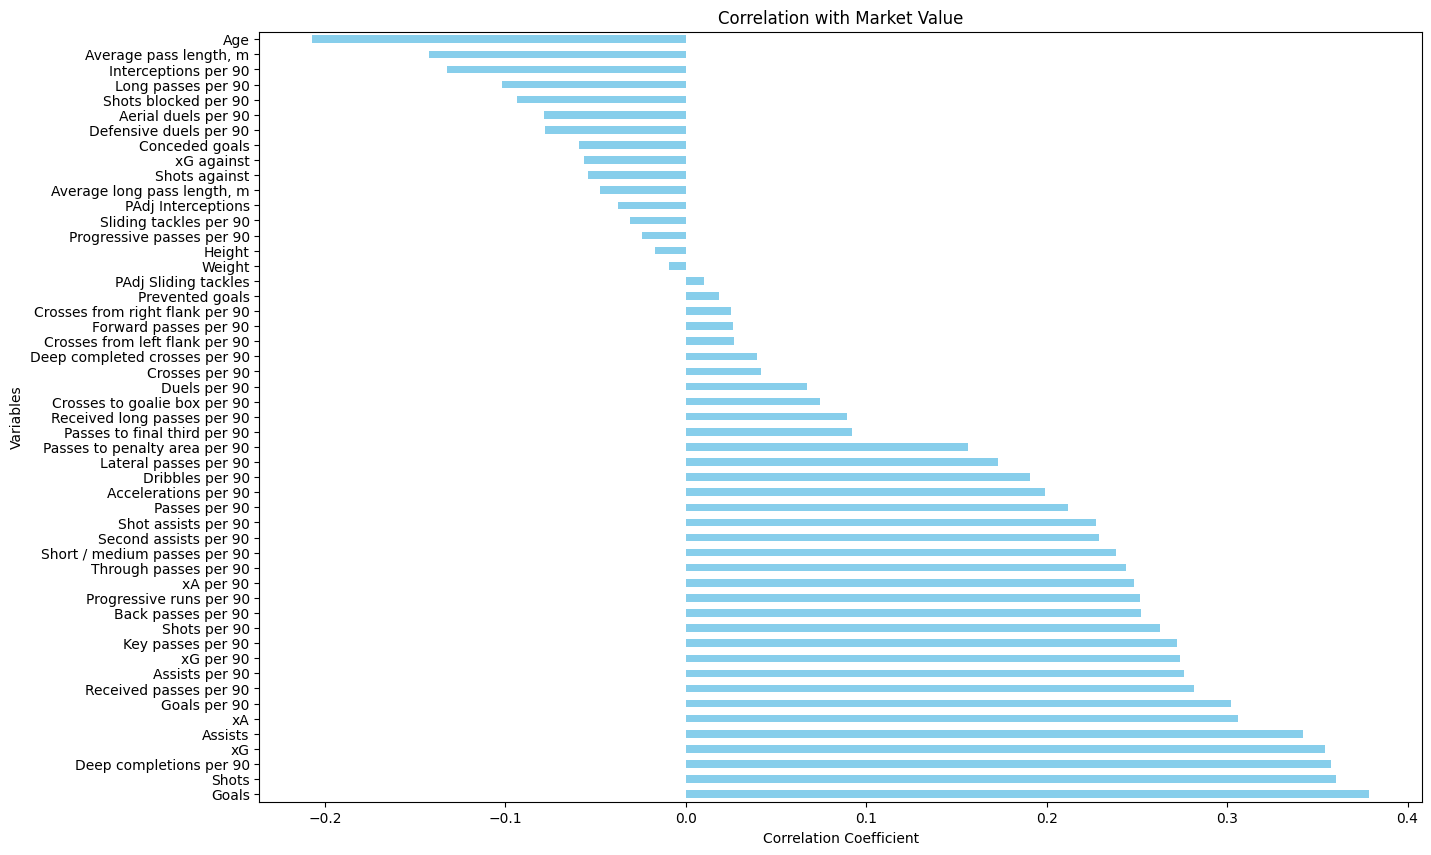

In [33]:
# Step 1: Extract correlations with 'Market value'
market_value_correlations = correlation_matrix['Market value'].sort_values(ascending=False)

# Step 2: Drop the 'Market value' correlation with itself
market_value_correlations = market_value_correlations.drop('Market value', errors='ignore')

# Step 3: Plot the correlations
plt.figure(figsize=(15, 10))
market_value_correlations.plot(kind='barh', color='skyblue')
plt.title('Correlation with Market Value')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.show()

In [5]:
def compute_vif(X_data):
    vif = pd.DataFrame()
    vif["feature"] = X_data.columns
    vif["VIF"] = [variance_inflation_factor(X_data.values, i) for i in range(X_data.shape[1])]
    return vif

def optimized_vif_removal(X_data):
    high_vif_features = []
    while True:
        vif = compute_vif(X_data)
        max_vif = vif["VIF"].max()
        if max_vif <= 10:
            break
        remove = vif.sort_values("VIF", ascending=False).iloc[0]
        high_vif_features.append(remove["feature"])
        X_data = X_data.drop(columns=remove["feature"])
    return X_data, high_vif_features

In [6]:

non_performance_metrics = ['Age', 'Height', 'Weight', 'Position 1_CB', 'Position 1_CF', 'Position 1_CM',
                           'Position 1_DMF', 'Position 1_LB', 'Position 1_LW', 'Position 1_LWB', 'Position 1_RB',
                           'Position 1_RW', 'Position 1_RWB', 'Position 1_AMF', 'Position 1_GK']


In [7]:
# Target variable
y = df['Market value']

# Extract only performance metrics
performance_metrics = [col for col in df.columns if col not in ['Player', 'Team', 'Age', 'Market value', 'Birth country', 'Height', 'Weight'] + non_performance_metrics]
X_perf = df[performance_metrics]

# Initial VIF for performance metrics
initial_vif_perf = compute_vif(X_perf)

# Iteratively remove features with high VIF for performance metrics
X_perf_final, dropped_perf = optimized_vif_removal(X_perf.copy())

# VIF after optimized removal for performance metrics
final_vif_perf = compute_vif(X_perf_final)

# Perform linear regression
X_with_const_perf = sm.add_constant(X_perf_final)
model_perf = sm.OLS(y, X_with_const_perf).fit()

# Output results
initial_vif_perf, dropped_perf, final_vif_perf, model_perf.summary()


(                            feature            VIF
 0                             Goals      54.955625
 1                                xG      88.588162
 2                           Assists      26.071897
 3                                xA      28.413852
 4                      Duels per 90      17.957073
 5            Defensive duels per 90       6.306723
 6               Aerial duels per 90       6.058124
 7            Sliding tackles per 90      94.034221
 8              PAdj Sliding tackles      94.679453
 9              Shots blocked per 90       3.244124
 10             Interceptions per 90      42.561798
 11               PAdj Interceptions      37.848595
 12                     Goals per 90      41.771813
 13                        xG per 90      76.855686
 14                            Shots      57.150866
 15                     Shots per 90      51.931994
 16                   Assists per 90      22.012013
 17                   Crosses per 90    2366.793016
 18   Crosse

In [8]:
X_non_perf = df[non_performance_metrics]
X_non_perf = X_non_perf.astype(int)


# Replace NaN values with the mean of the column
X_non_perf.fillna(X_non_perf.mean(), inplace=True)

# Replace infinite values (this is just one approach, depending on your data you might need a different one)
X_non_perf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initial VIF for non-performance metrics
initial_vif_non_perf = compute_vif(X_non_perf)

# Iteratively remove features with high VIF for non-performance metrics
X_non_perf_final, dropped_non_perf = optimized_vif_removal(X_non_perf.copy())

# VIF after optimized removal for non-performance metrics
final_vif_non_perf = compute_vif(X_non_perf_final)

# Perform linear regression
X_with_const_non_perf = sm.add_constant(X_non_perf_final)
model_non_perf = sm.OLS(y, X_with_const_non_perf).fit()

# Output results
initial_vif_non_perf, dropped_non_perf, final_vif_non_perf, model_non_perf.summary()


(           feature       VIF
 0              Age  1.053504
 1           Height  1.820600
 2           Weight  1.793347
 3    Position 1_CB  1.103306
 4    Position 1_CF  1.020213
 5    Position 1_CM  1.013613
 6   Position 1_DMF  1.006207
 7    Position 1_LB  1.017300
 8    Position 1_LW  1.033289
 9   Position 1_LWB  1.001632
 10   Position 1_RB  1.024167
 11   Position 1_RW  1.030836
 12  Position 1_RWB  1.001783
 13  Position 1_AMF  1.046250
 14   Position 1_GK  1.171592,
 [],
            feature       VIF
 0              Age  1.053504
 1           Height  1.820600
 2           Weight  1.793347
 3    Position 1_CB  1.103306
 4    Position 1_CF  1.020213
 5    Position 1_CM  1.013613
 6   Position 1_DMF  1.006207
 7    Position 1_LB  1.017300
 8    Position 1_LW  1.033289
 9   Position 1_LWB  1.001632
 10   Position 1_RB  1.024167
 11   Position 1_RW  1.030836
 12  Position 1_RWB  1.001783
 13  Position 1_AMF  1.046250
 14   Position 1_GK  1.171592,
 <class 'statsmodels.iolib.summar

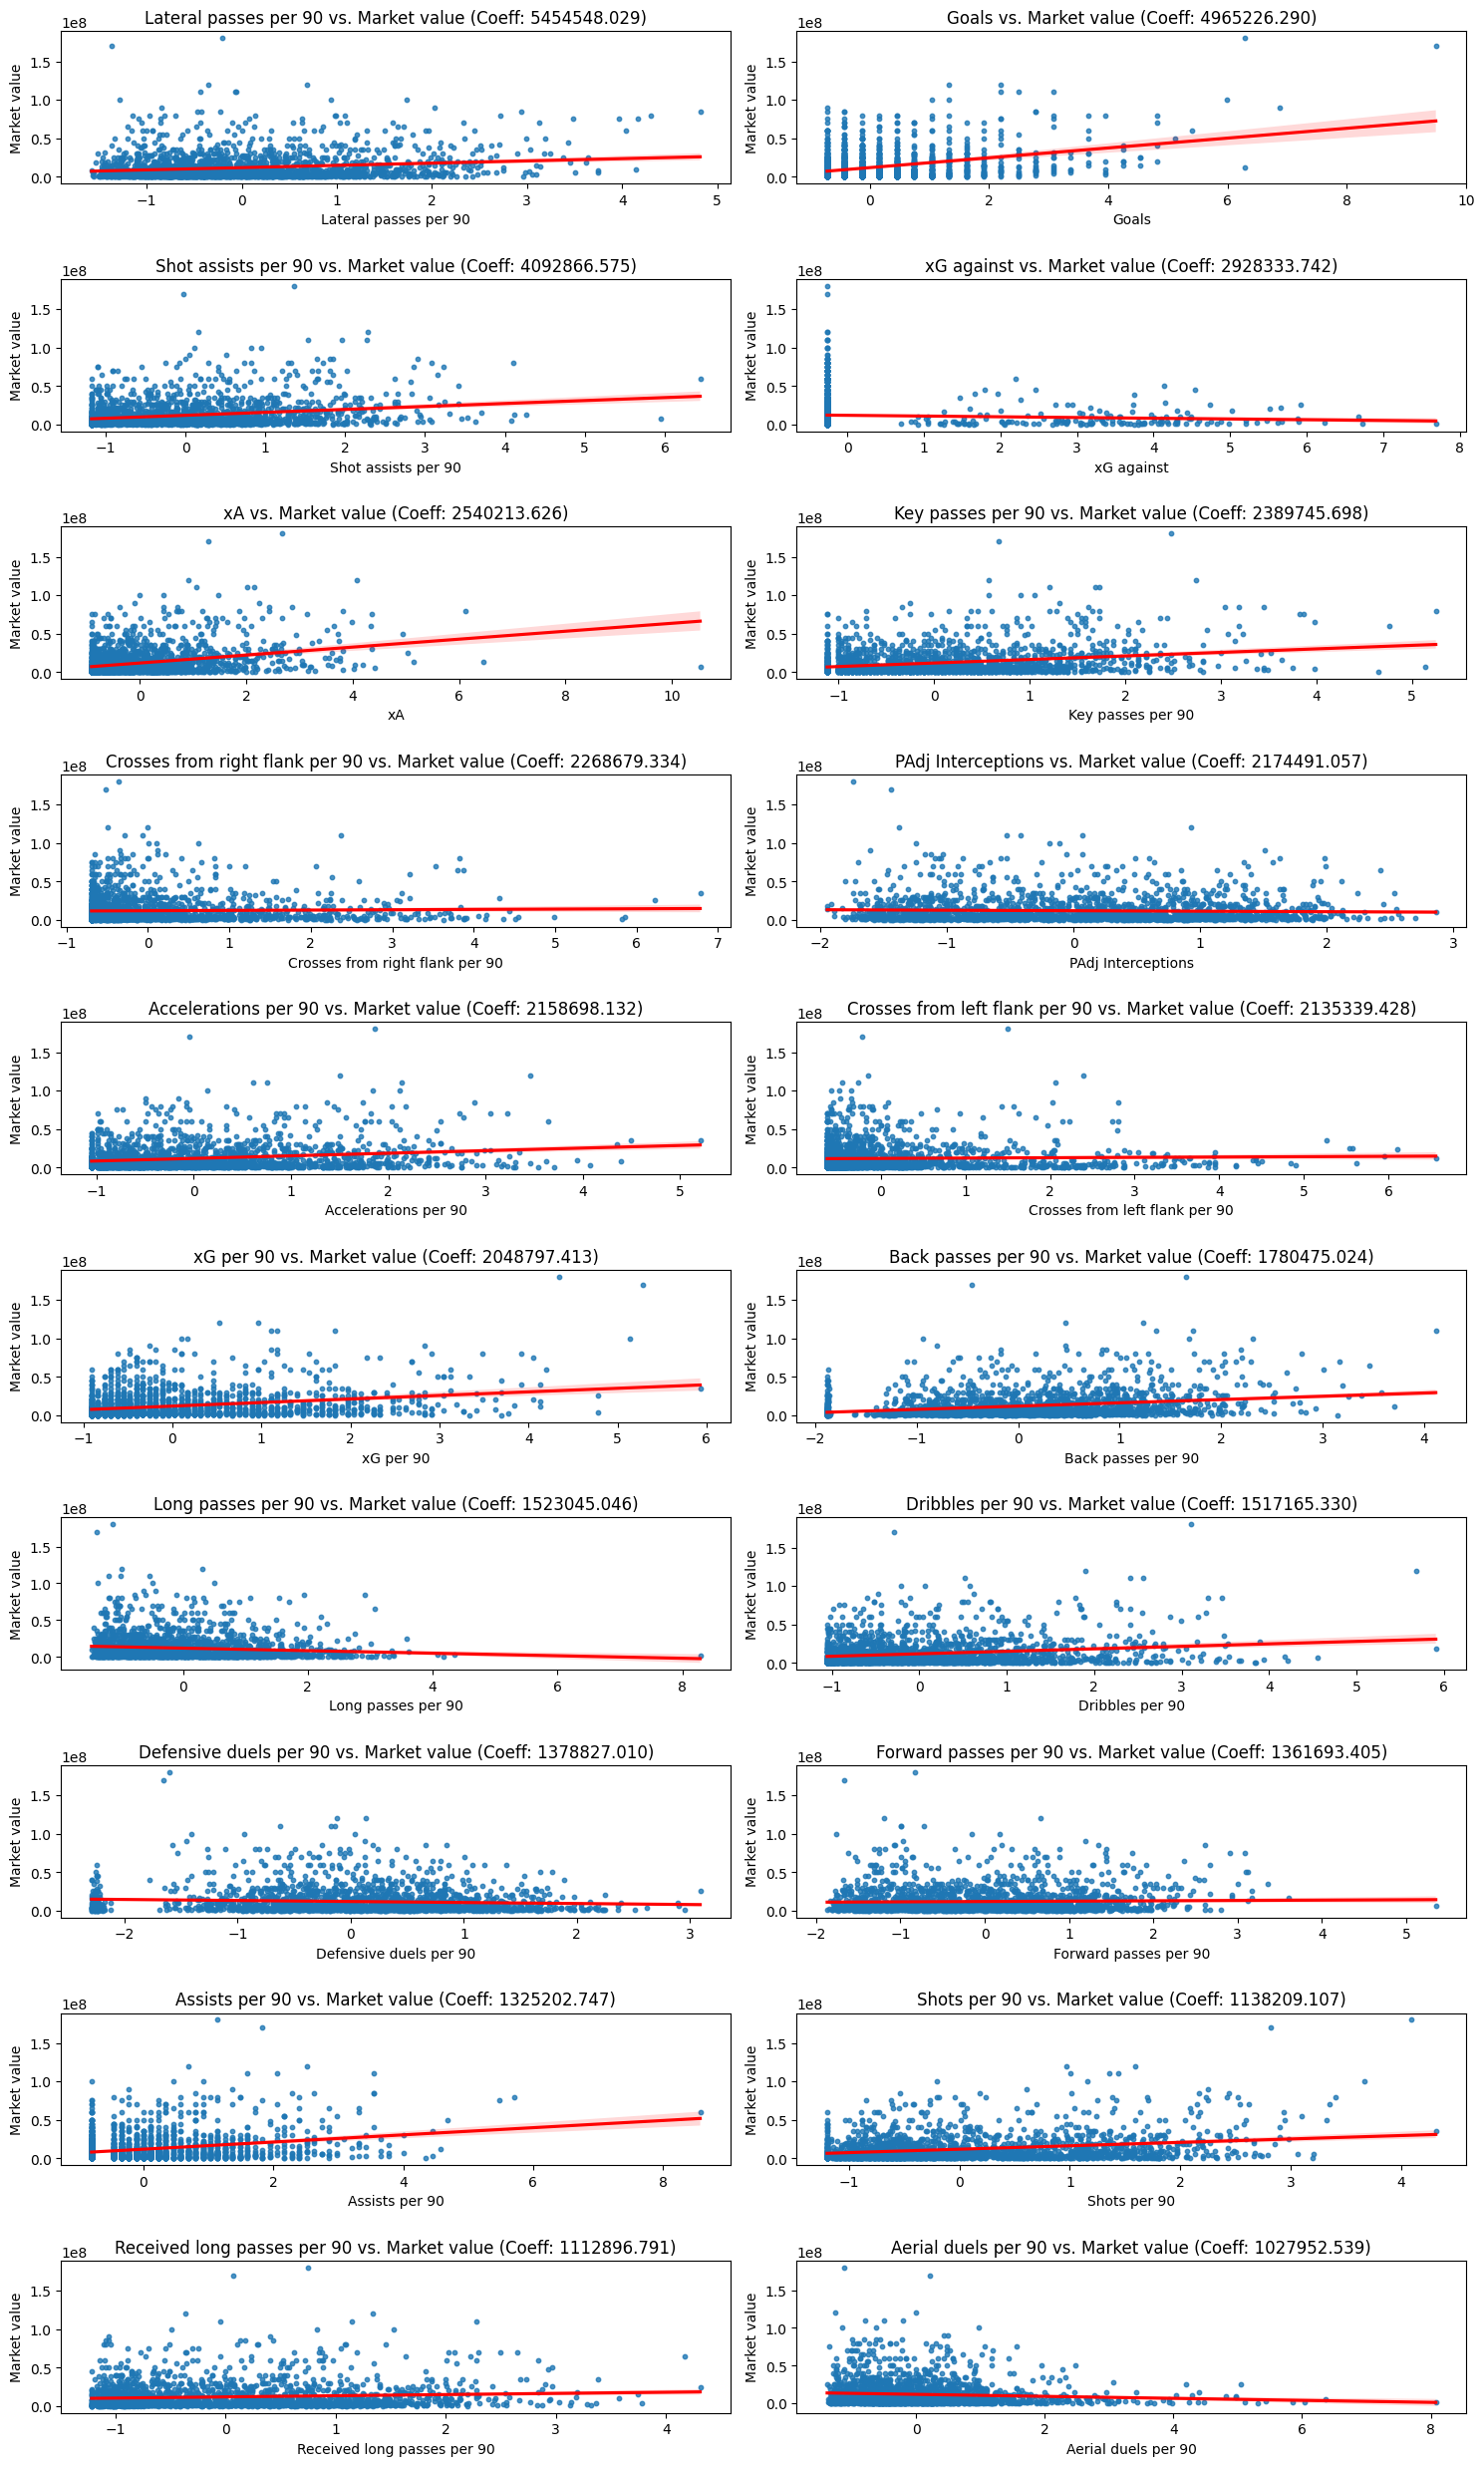

In [37]:
# Extract the coefficients from the regression model, excluding the constant
perf_coefficients = model_perf.params.drop('const')

# Rank the coefficients in descending order to get the top 10
top_8_perf_coefficients = perf_coefficients.abs().sort_values(ascending=False).head(20)

# Create scatter plots comparing each of the top 10 performance metrics to market value
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(15, 25))

for i, (metric, coeff) in enumerate(top_8_perf_coefficients.items()):
    row = i // 2
    col = i % 2
    sns.regplot(x=df[metric], y=df['Market value'], ax=axes[row, col], scatter_kws={'s':10}, line_kws={'color':'red'})
    axes[row, col].set_title(f'{metric} vs. Market value (Coeff: {coeff:.3f})')
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_ylabel('Market value')

plt.tight_layout()
plt.show()

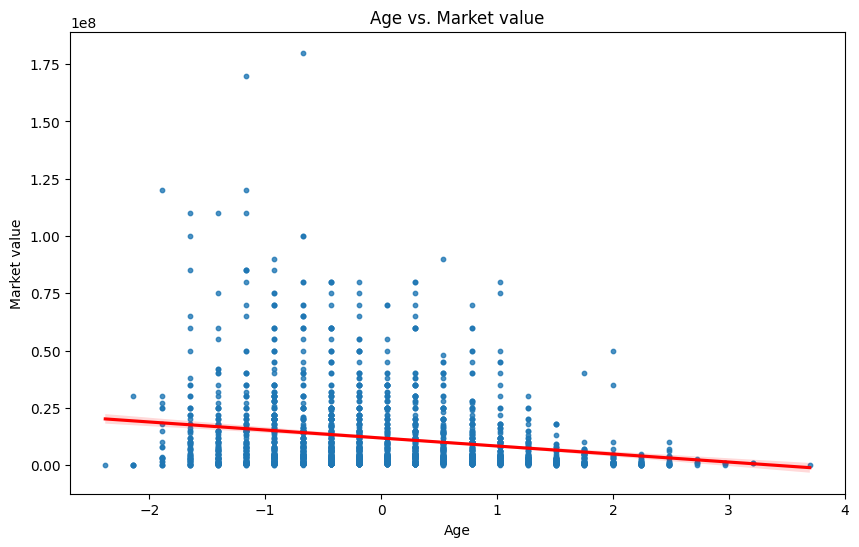

In [10]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df['Age'], y=df['Market value'], scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Age vs. Market value')
plt.xlabel('Age')
plt.ylabel('Market value')
plt.show()

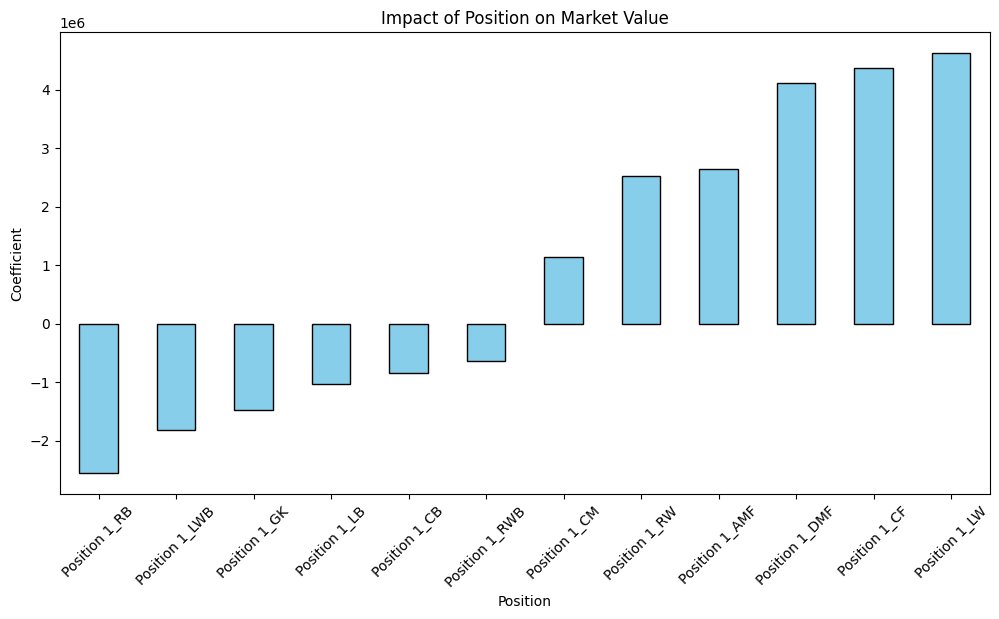

In [11]:
# Extracting the coefficients related to the position dummy variables
position_coefficients = model_non_perf.params[model_non_perf.params.index.str.startswith('Position 1_')]

# Visualizing the impact of positions on market value using a bar chart
plt.figure(figsize=(12, 6))
position_coefficients.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Position')
plt.ylabel('Coefficient')
plt.title('Impact of Position on Market Value')
plt.xticks(rotation=45)
plt.show()

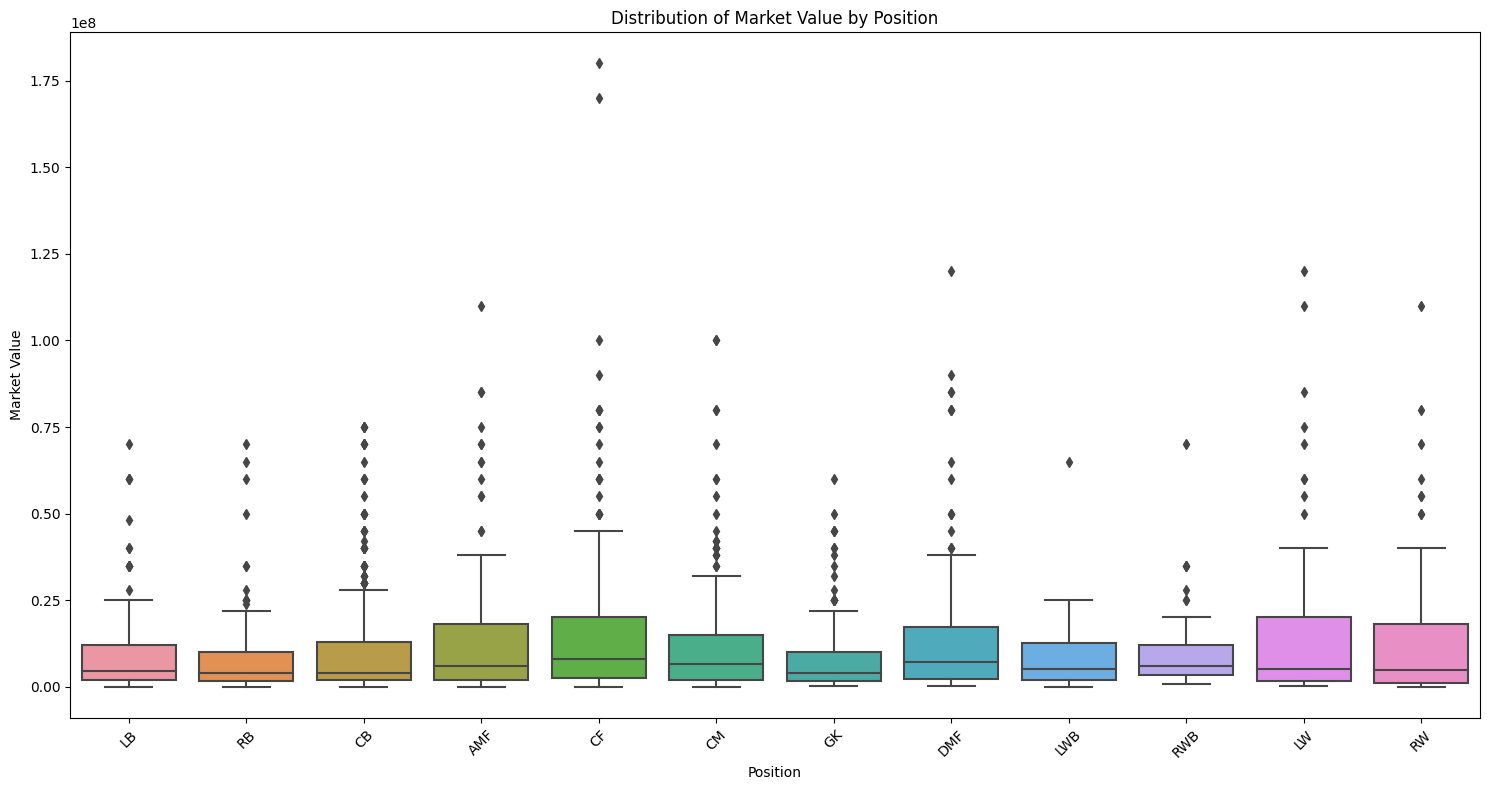

In [12]:
# Identify all columns related to position dummy variables
position_columns = [col for col in df.columns if col.startswith('Position 1_')]

# Convert these columns back into a single 'Position' column
df['Position'] = df[position_columns].idxmax(axis=1)
df['Position'] = df['Position'].str.replace('Position 1_', '')

# Box plot code
plt.figure(figsize=(15, 8))
sns.boxplot(x='Position', y='Market value', data=df)
plt.xlabel('Position')
plt.ylabel('Market Value')
plt.title('Distribution of Market Value by Position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

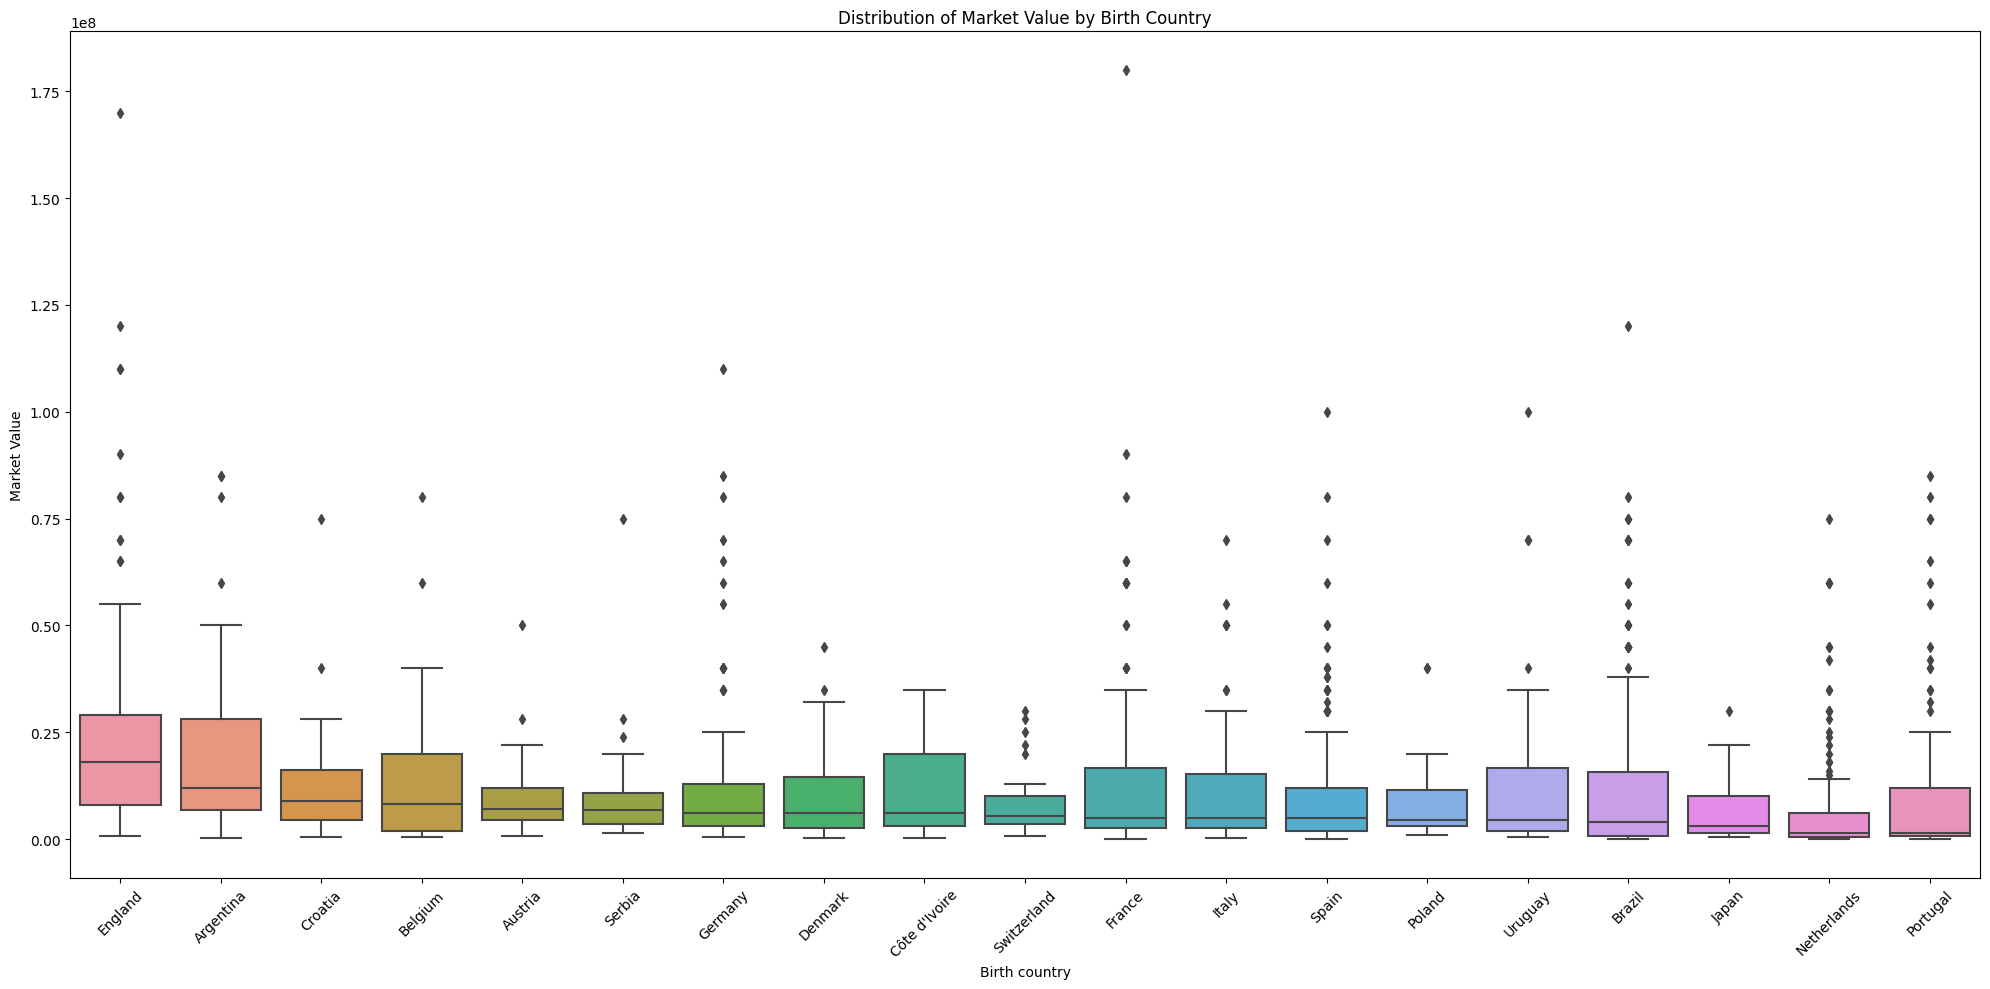

In [13]:
# Filter countries with more than 20 players
countries_count = df['Birth country'].value_counts()
countries_to_include = countries_count[countries_count > 20].index

filtered_df = df[df['Birth country'].isin(countries_to_include)]

# Box plot code
plt.figure(figsize=(20, 10))
sns.boxplot(x='Birth country', y='Market value', data=filtered_df, order=filtered_df.groupby('Birth country')['Market value'].median().sort_values(ascending=False).index)
plt.xlabel('Birth country')
plt.ylabel('Market Value')
plt.title('Distribution of Market Value by Birth Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
initial_vif_perf_df = pd.DataFrame(initial_vif_perf)
final_vif_perf_df = pd.DataFrame(final_vif_perf)

In [15]:
summary_table = model_perf.summary().tables[1]
model_perf_df = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])

In [20]:
sorted_initial_vif_perf = initial_vif_perf_df.sort_values(by='VIF', ascending=False)
sorted_initial_vif_perf


,feature,VIF
44,Conceded goals,199851.899008
46,xG against,199451.671560
26,Passes per 90,46650.201625
30,Short / medium passes per 90,42306.299318
47,Prevented goals,4402.541022
17,Crosses per 90,2366.793016
31,Long passes per 90,1597.824422
19,Crosses from right flank per 90,1072.763630
18,Crosses from left flank per 90,1057.636462
8,PAdj Sliding tackles,94.679453


In [22]:
sorted_initial_vif_non_perf = initial_vif_non_perf.sort_values(by='VIF', ascending=False)
sorted_initial_vif_non_perf


,feature,VIF
1,Height,1.820600
2,Weight,1.793347
14,Position 1_GK,1.171592
3,Position 1_CB,1.103306
0,Age,1.053504
13,Position 1_AMF,1.046250
8,Position 1_LW,1.033289
11,Position 1_RW,1.030836
10,Position 1_RB,1.024167
4,Position 1_CF,1.020213


In [17]:
final_vif_perf_df

,feature,VIF
0,Goals,3.990698
1,xA,5.339883
2,Defensive duels per 90,3.169028
3,Aerial duels per 90,2.154822
4,Sliding tackles per 90,1.331534
5,Shots blocked per 90,2.760458
6,PAdj Interceptions,4.313873
7,xG per 90,9.900249
8,Shots per 90,8.381581
9,Assists per 90,2.416420


In [32]:
model_perf_df['coef'] = model_perf_df['coef'].astype(float)
model_perf_df.sort_values(by='coef', ascending=False)

,,coef,std err,t,P>|t|,[0.025,0.975]
0,const,11820000.0,2.98e+05,39.613,0.000,1.12e+07,1.24e+07
20,Lateral passes per 90,5455000.0,5.79e+05,9.420,0.000,4.32e+06,6.59e+06
1,Goals,4965000.0,5.96e+05,8.328,0.000,3.8e+06,6.13e+06
29,xG against,2928000.0,5.97e+05,4.908,0.000,1.76e+06,4.1e+06
2,xA,2540000.0,6.9e+05,3.683,0.000,1.19e+06,3.89e+06
25,Key passes per 90,2390000.0,7.41e+05,3.226,0.001,9.37e+05,3.84e+06
7,PAdj Interceptions,2174000.0,6.2e+05,3.508,0.000,9.59e+05,3.39e+06
16,Accelerations per 90,2159000.0,6.18e+05,3.494,0.000,9.47e+05,3.37e+06
8,xG per 90,2049000.0,9.39e+05,2.182,0.029,2.07e+05,3.89e+06
19,Back passes per 90,1780000.0,5.66e+05,3.144,0.002,6.7e+05,2.89e+06


In [35]:
dropped_perf_df = pd.DataFrame(dropped_perf)
dropped_perf_df

,0
0,Conceded goals
1,Passes per 90
2,Crosses per 90
3,Short / medium passes per 90
4,PAdj Sliding tackles
5,xG
6,Shots against
7,Received passes per 90
8,Shots
9,Passes to penalty area per 90
